In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

!gdown https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90
!gdown https://drive.google.com/uc?id=18BuPskF5yQNZpGMv9nzDuSe20KCmEwvU

# Definir rutas
zip_path = '/content/split_data608.zip'
extract_path = '/content'

# Crear carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivo descomprimido en:", extract_path)

# Definir rutas
zip_path = '/content/DDMP_UNet-20250629T195613Z-1-001.zip'
extract_path = '/content'

# Crear carpeta de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivo descomprimido en:", extract_path)

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90
From (redirected): https://drive.google.com/uc?id=1JkCpzOk8qqakxUW-phQi6JeAah_mIn90&confirm=t&uuid=fbda4af8-f199-4205-a840-29299a27037d
To: /content/split_data608.zip
100% 1.48G/1.48G [00:15<00:00, 93.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=18BuPskF5yQNZpGMv9nzDuSe20KCmEwvU
From (redirected): https://drive.google.com/uc?id=18BuPskF5yQNZpGMv9nzDuSe20KCmEwvU&confirm=t&uuid=12fc158b-0cac-44d8-b719-98ecfaa817fc
To: /content/DDMP_UNet-20250629T195613Z-1-001.zip
100% 979M/979M [00:11<00:00, 88.8MB/s]
Archivo descomprimido en: /content
Archivo descomprimido en: /content


In [ ]:
!pip install lightning --quiet
!pip install torchviz --quiet
!pip install hiddenlayer --quiet
!pip install onnx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.2/825.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 53.5 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image

def check_image_sizes(directory):
    sizes = {}
    print(f"\n📂 Analizando: {directory}")
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        try:
            with Image.open(path) as img:
                size = img.size  # (width, height)
                sizes[size] = sizes.get(size, 0) + 1
        except Exception as e:
            print(f"❌ Error con {filename}: {e}")

    for size, count in sizes.items():
        print(f"🖼️ {count} imágenes de tamaño {size[0]}x{size[1]}")
    if not sizes:
        print("⚠️ No se encontraron imágenes válidas.")

# Carpetas a verificar
check_image_sizes("/content/split_data/train/acs")  # LR
check_image_sizes("/content/split_data/train/dud")  # HR
check_image_sizes("/content/split_data/val/acs")    # LR
check_image_sizes("/content/split_data/val/dud")    # HR


📂 Analizando: /content/split_data/train/acs
🖼️ 103129 imágenes de tamaño 608x608

📂 Analizando: /content/split_data/train/dud
🖼️ 103129 imágenes de tamaño 152x152

📂 Analizando: /content/split_data/val/acs
🖼️ 12891 imágenes de tamaño 608x608

📂 Analizando: /content/split_data/val/dud
🖼️ 12891 imágenes de tamaño 152x152


In [ ]:
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
import os, glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import lightning as L
from lightning.fabric.utilities.seed import seed_everything
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping

import sys
sys.path.append("/content/DDMP_UNet")
from src.callbacks.metrics_new import MetricsCallbackDDPM
from src.ddpm.ddpm_A import DDPM_2D

In [ ]:
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512],
    loss_fn=nn.MSELoss(),
)

# Simulamos entrada y referencia con resolución 152x152
x = torch.randn(1, 1, 152, 152)        # Imagen original
ref = torch.randn(1, 1, 152, 152)      # Imagen de referencia
t = torch.tensor([0])                 # Un paso temporal arbitrario

# Concatenamos en canal: [1, 2, 152, 152]
x_cat = torch.cat([x, ref], dim=1)

# Pasamos por el modelo
out = ddpm_model(x_cat, t)

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
print(ddpm_model)

DDPM_2D(
  (loss): MSELoss()
  (time_embedding): PositionalEncoding()
  (model): UNetSuperRes(
    (loss_fn): MSELoss()
    (downs): ModuleList(
      (0): Down_Res_GroupNorm_SiLU_D(
        (module): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): ResBlockGroupNorm(
            (main_path): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): GroupNorm(32, 128, eps=0.001, affine=True)
              (2): SiLU(inplace=True)
              (3): Dropout(p=0.1, inplace=False)
              (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): GroupNorm(32, 128, eps=0.001, affine=True)
              (6): SiLU(inplace=True)
              (7): Dropout(p=0.1, inplace=False)
            )
            (residual_connection): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
       

In [ ]:
from torchsummary import summary

# Ejemplo con batch=1, 2 canales, 152x152
summary(ddpm_model, input_size=(2, 152, 152))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 152, 152]             128
            Conv2d-2         [-1, 64, 152, 152]           1,152
         GroupNorm-3         [-1, 64, 152, 152]             128
              SiLU-4         [-1, 64, 152, 152]               0
           Dropout-5         [-1, 64, 152, 152]               0
            Conv2d-6         [-1, 64, 152, 152]          36,864
         GroupNorm-7         [-1, 64, 152, 152]             128
              SiLU-8         [-1, 64, 152, 152]               0
           Dropout-9         [-1, 64, 152, 152]               0
ResBlockGroupNorm-10         [-1, 64, 152, 152]               0
        MaxPool2d-11           [-1, 64, 76, 76]               0
           Conv2d-12          [-1, 128, 76, 76]           8,192
           Conv2d-13          [-1, 128, 76, 76]          73,728
        GroupNorm-14          [-1, 128,

In [ ]:
from torchviz import make_dot

# Prepara una entrada de ejemplo
x = torch.randn(1, 2, 152, 152)  # 2 canales por la concatenación
t = torch.randint(0, 400, (1,), dtype=torch.long)

ddpm_model.eval()
out = ddpm_model(x, t)

# Visualiza el grafo de cómputo
dot = make_dot(out, params=dict(ddpm_model_superres.named_parameters()))
dot.format = "png"
dot.render("ddpm_model_graph_make_dot")  # genera 'ddpm_model_graph.png'
dot.view()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [ ]:
dummy_input = (torch.randn(1, 2, 152, 152), torch.tensor([0]))
torch.onnx.export(ddpm_model, dummy_input, "ddpm_model.onnx",
                  input_names=["x", "t"], output_names=["output"],
                  opset_version=11)


In [ ]:
with torch.no_grad():
    ddpm_model.eval()
    out = ddpm_model(x_cat, t)
    print(f"[AFTER CALL] Output shape: {out.shape}")

[AFTER CALL] Output shape: torch.Size([1, 1, 152, 152])


In [ ]:
with torch.no_grad():
    ddpm_model.eval()
    out = ddpm_model.forward(x_cat, t)


# Super Resolución

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model, upscale_factor=4):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=True),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Conv para afinar después del upsampling
        )

    def forward(self, x, t=None):
        out = self.ddpm(x, t)
        out_up = self.upscale(out)
        return out_up
# Modelo original
ddpm_model = DDPM_2D(
    in_channels=1,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
)

# Envuelto con superresolución
ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model, upscale_factor=4)


[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
x = torch.randn(1, 2, 152, 152)
t = torch.tensor([0])

ddpm_model_superres.eval()
with torch.no_grad():
    y = ddpm_model_superres(x, t)
    print("Output shape:", y.shape)  # Esperado: [1, 1, 608, 608]

Output shape: torch.Size([1, 1, 608, 608])


In [ ]:
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
import os, glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import lightning as L
from lightning.fabric.utilities.seed import seed_everything
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping

import sys
sys.path.append("/content/DDMP_UNet")
from src.callbacks.metrics_new import MetricsCallbackDDPM
from src.ddpm.ddpm_A import DDPM_2D

In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint(
    monitor='val/loss',
    save_top_k=1,
    mode='min',
    filename='ddpm-superres-best'
)

early_stop_cb = EarlyStopping(
    monitor='val/loss',
    patience=10,
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name="ddpm_superres")

# Semilla
seed_everything(42)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [ ]:
# Ruta en Google Drive
drive_output_path = "/content/drive/MyDrive/Entrenamiento superResolucion"

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Logger en carpeta de Drive
logger = TensorBoardLogger(
    save_dir=drive_output_path,
    name="logs"
)

# Guardar el mejor modelo (por val/loss mínimo)
checkpoint_best = ModelCheckpoint(
    dirpath=drive_output_path,
    filename="best-checkpoint",
    monitor="val/loss",
    save_top_k=1,
    mode="min",
    save_weights_only=False,
)

# Guardar modelo en CADA epoch (con nombre por epoch)
checkpoint_all = ModelCheckpoint(
    dirpath=drive_output_path,
    filename="epoch-{epoch:02d}-val_loss-{val/loss:.4f}",
    save_top_k=-1,  # Guardar todos
    every_n_epochs=1,
    save_weights_only=False,
)


In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ruta en Google Drive
save_dir = "/content/drive/MyDrive/Entrenamiento superResolucion"
os.makedirs(save_dir, exist_ok=True)

# Modelo
ddpm_model = DDPM_2D(
    in_channels=1,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512],
    loss_fn=nn.MSELoss(),
).to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


In [ ]:
from torchviz import make_dot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm_model_superres.to(device)

x = torch.randn(1, 2, 152, 152).to(device)
t = torch.randint(0, 400, (1,), dtype=torch.long).to(device)

ddpm_model_superres.eval()
out = ddpm_model_superres(x, t)

dot = make_dot(out, params=dict(ddpm_model_superres.named_parameters()))
dot.format = "png"
dot.render("ddpm_model_graph_make_dot")
dot.view()


'ddpm_model_graph_make_dot.png'

In [ ]:
from torchsummary import summary

# Ejemplo con batch=1, 2 canales, 152x152
summary(ddpm_model_superres, input_size=(2, 152, 152))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 152, 152]             128
            Conv2d-2         [-1, 64, 152, 152]           1,152
         GroupNorm-3         [-1, 64, 152, 152]             128
              SiLU-4         [-1, 64, 152, 152]               0
           Dropout-5         [-1, 64, 152, 152]               0
            Conv2d-6         [-1, 64, 152, 152]          36,864
         GroupNorm-7         [-1, 64, 152, 152]             128
              SiLU-8         [-1, 64, 152, 152]               0
           Dropout-9         [-1, 64, 152, 152]               0
ResBlockGroupNorm-10         [-1, 64, 152, 152]               0
        MaxPool2d-11           [-1, 64, 76, 76]               0
           Conv2d-12          [-1, 128, 76, 76]           8,192
           Conv2d-13          [-1, 128, 76, 76]          73,728
        GroupNorm-14          [-1, 128,

# Entrenamiento!!

In [ ]:
#No ruido
import os
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn

from torchvision.transforms import functional as TVF  # Para transformaciones de imagen
import torch.nn.functional as F  # Para funciones de pérdida
from torch.utils.data import Dataset  # Añade esto si falta

class DDPM_SuperRes_Wrapper(nn.Module):
    def __init__(self, ddpm_model, upscale_factor=4):
        super().__init__()
        self.ddpm = ddpm_model
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=True),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1)
        )
        self.duplicate_channel = lambda x: torch.cat([x, x], dim=1)

    def forward(self, x, t=None):  # Hacemos t opcional
        x_2ch = self.duplicate_channel(x)
        # Si no se proporciona t, asumimos modo sin difusión
        if t is None:
            out = self.ddpm(x_2ch)  # Sin parámetro t
        else:
            out = self.ddpm(x_2ch, t)
        return self.upscale(out)

#===================================================================

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = os.listdir(lr_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, filename)
        hr_path = os.path.join(self.hr_dir, filename)

        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        # Convertir a grayscale
        lr_gray = TVF.to_grayscale(lr_img, num_output_channels=1)  # Cambiado
        hr_gray = TVF.to_grayscale(hr_img, num_output_channels=1)  # Cambiado
        return {
            'lr': self.transform(lr_gray),
            'hr': self.transform(hr_gray)
        }

train_dataset = SRDataset(
    hr_dir='/content/split_data/train/acs/',
    lr_dir='/content/split_data/train/dud/'
)

val_dataset = SRDataset(
    hr_dir='/content/split_data/val/acs/',
    lr_dir='/content/split_data/val/dud/'
)

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2)

# =================================================================================

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = "/content/drive/MyDrive/Entrenamiento superResolucion"

# Crear directorio si no existe
os.makedirs(save_dir, exist_ok=True)

# Hiperparámetros
num_epochs = 1
lr = 1e-3

# Modelo y optimizador
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=lr,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model, upscale_factor=4).to(device)
optimizer = torch.optim.Adam(ddpm_model_superres.parameters(), lr=lr)

# Entrenamiento
best_val_loss = float('inf')
history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': []
}

for epoch in range(num_epochs):
    ddpm_model_superres.train()
    train_losses = []

    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch in train_pbar:
        x_lr = batch["lr"].to(device)
        x_hr = batch["hr"].to(device)

        optimizer.zero_grad()
        pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t

        # Usamos torch.nn.functional.mse_loss
        loss = F.mse_loss(pred_hr, x_hr)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_pbar.set_postfix({'loss': loss.item()})

    # Validación
    ddpm_model_superres.eval()
    val_losses = []

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        for batch in val_pbar:
            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t
            val_loss = F.mse_loss(pred_hr, x_hr)
            val_losses.append(val_loss.item())
            val_pbar.set_postfix({'val_loss': val_loss.item()})

    # Calcular métricas
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Guardar histórico
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    # Guardar estadísticas en CSV
    stats_df = pd.DataFrame(history)
    stats_df.to_csv(os.path.join(save_dir, 'training_stats.csv'), index=False)

    # Guardar modelo cada época
    epoch_model_path = os.path.join(save_dir, f'model_epoch_{epoch+1:03d}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': ddpm_model_superres.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, epoch_model_path)

    # Guardar mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ddpm_model_superres.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, best_model_path)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

print("¡Entrenamiento completado!")

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32
[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


Epoch 1/1 [Train]:   0%|          | 8/2149 [00:03<14:05,  2.53it/s, loss=0.00188]


KeyboardInterrupt: 

In [ ]:
# Cargar el modelo:
# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = "/content/drive/MyDrive/Entrenamiento superResolucion"

# Cargar el mejor modelo guardado
checkpoint = torch.load(os.path.join(save_dir, 'model_epoch_032.pth'))

# Recrear la arquitectura del modelo (idéntica a la original)
ddpm_model = DDPM_2D(
    in_channels=2,
    out_channels=1,
    diffusion_steps=400,
    dropout=0.10,
    lr=1e-3,
    encoder_channels=[64, 128, 256, 512, 1024],
    loss_fn=nn.MSELoss(),
).to(device)

ddpm_model_superres = DDPM_SuperRes_Wrapper(ddpm_model, upscale_factor=4).to(device)
optimizer = torch.optim.Adam(ddpm_model_superres.parameters(), lr=1e-3)

# Cargar los estados guardados
ddpm_model_superres.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Obtener la última época y pérdidas
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']

# Cargar el historial de entrenamiento
history_path = os.path.join(save_dir, 'training_stats.csv')
if os.path.exists(history_path):
    history_df = pd.read_csv(history_path)
    history = {
        'epoch': history_df['epoch'].tolist(),
        'train_loss': history_df['train_loss'].tolist(),
        'val_loss': history_df['val_loss'].tolist()
    }
else:
    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': []
    }

# Continuar entrenamiento SIN RUIDO
additional_epochs = 100
total_epochs = start_epoch + additional_epochs

for epoch in range(start_epoch, total_epochs):
    ddpm_model_superres.train()
    train_losses = []

    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{total_epochs} [Train]'):
        x_lr = batch["lr"].to(device)
        x_hr = batch["hr"].to(device)

        optimizer.zero_grad()
        pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t
        loss = F.mse_loss(pred_hr, x_hr)  # Pérdida directa MSE
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validación (también sin ruido)
    ddpm_model_superres.eval()
    val_losses = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{total_epochs} [Val]'):
            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            pred_hr = ddpm_model_superres(x_lr)  # Sin parámetro t
            val_loss = F.mse_loss(pred_hr, x_hr)  # Pérdida directa MSE
            val_losses.append(val_loss.item())

    # Actualizar métricas
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)

    history['epoch'].append(epoch + 1)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    # Guardar checkpoints
    stats_df = pd.DataFrame(history)
    stats_df.to_csv(os.path.join(save_dir, 'training_stats.csv'), index=False)

    epoch_model_path = os.path.join(save_dir, f'model_epoch_{epoch+1:03d}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': ddpm_model_superres.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, epoch_model_path)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ddpm_model_superres.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, best_model_path)

    print(f'Epoch {epoch+1}/{total_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

print("¡Entrenamiento continuado completado!")

[DownBlock] in=64, out=128, groups_in=32, groups_out=32
[DownBlock] in=128, out=256, groups_in=32, groups_out=32


Epoch 33/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.56it/s]


Epoch 33/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 34/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.50it/s]


Epoch 34/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 35/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.12it/s]


Epoch 35/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 36/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.37it/s]


Epoch 36/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 37/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.00it/s]


Epoch 37/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 38/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.66it/s]


Epoch 38/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 39/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.39it/s]


Epoch 39/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 40/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.17it/s]


Epoch 40/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 41/132 [Val]: 100%|██████████| 12891/12891 [01:24<00:00, 151.71it/s]


Epoch 41/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 42/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.57it/s]


Epoch 42/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 43/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.15it/s]


Epoch 43/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 44/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.76it/s]


Epoch 44/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 45/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.71it/s]


Epoch 45/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 46/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.50it/s]


Epoch 46/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 47/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 148.70it/s]


Epoch 47/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 48/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.27it/s]


Epoch 48/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 49/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.82it/s]


Epoch 49/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 50/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.28it/s]


Epoch 50/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 51/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.22it/s]


Epoch 51/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 52/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.31it/s]


Epoch 52/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 53/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 148.31it/s]


Epoch 53/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 54/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.66it/s]


Epoch 54/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 55/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.80it/s]


Epoch 55/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 56/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.12it/s]


Epoch 56/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 57/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.83it/s]


Epoch 57/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 58/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.11it/s]


Epoch 58/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 59/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.83it/s]


Epoch 59/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 60/132 [Val]: 100%|██████████| 12891/12891 [01:24<00:00, 152.00it/s]


Epoch 60/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 61/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.84it/s]


Epoch 61/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 62/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.51it/s]


Epoch 62/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 63/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.57it/s]


Epoch 63/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 64/132 [Val]: 100%|██████████| 12891/12891 [01:27<00:00, 147.65it/s]


Epoch 64/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 65/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.31it/s]


Epoch 65/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 66/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 149.96it/s]


Epoch 66/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 67/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.57it/s]


Epoch 67/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 68/132 [Val]: 100%|██████████| 12891/12891 [01:27<00:00, 148.13it/s]


Epoch 68/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 69/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 149.97it/s]


Epoch 69/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 70/132 [Val]: 100%|██████████| 12891/12891 [01:26<00:00, 149.89it/s]


Epoch 70/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 71/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.07it/s]


Epoch 71/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 72/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.85it/s]


Epoch 72/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 73/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.30it/s]


Epoch 73/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 74/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.83it/s]


Epoch 74/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 75/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.75it/s]


Epoch 75/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 76/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 151.25it/s]


Epoch 76/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 77/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.71it/s]


Epoch 77/132 | Train Loss: 0.0000 | Val Loss: 0.0001


Epoch 78/132 [Val]: 100%|██████████| 12891/12891 [01:25<00:00, 150.41it/s]


Epoch 78/132 | Train Loss: 0.0000 | Val Loss: 0.0000


Epoch 79/132 [Train]:   1%|          | 17/2149 [00:03<06:29,  5.48it/s]

# Visualizar Resultados:

In [ ]:
# Crear dataset de test
test_dataset = SRDataset(
    hr_dir='/content/split_data/test/acs/',
    lr_dir='/content/split_data/test/dud/'
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(model, dataloader, num_examples=3):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_examples:
                break

            x_lr = batch["lr"].to(device)
            x_hr = batch["hr"].to(device)

            # Generar predicción
            t = torch.zeros(1, dtype=torch.long, device=device)  # Usamos t=0 para generación
            pred = model(x_lr, t)

            # Convertir a numpy y desnormalizar si es necesario
            lr_img = x_lr[0].cpu().numpy().squeeze()
            hr_img = x_hr[0].cpu().numpy().squeeze()
            pred_img = pred[0].cpu().numpy().squeeze()

            # Visualizar
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(lr_img, cmap='gray')
            plt.title(f'Low-Res Input\n{lr_img.shape}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(pred_img, cmap='gray')
            plt.title(f'Model Prediction\n{pred_img.shape}')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(hr_img, cmap='gray')
            plt.title(f'Ground Truth\n{hr_img.shape}')
            plt.axis('off')

            plt.show()


In [ ]:
# Cargar el mejor modelo guardado
checkpoint = torch.load(os.path.join(save_dir, 'best_model.pth'))
ddpm_model_superres.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

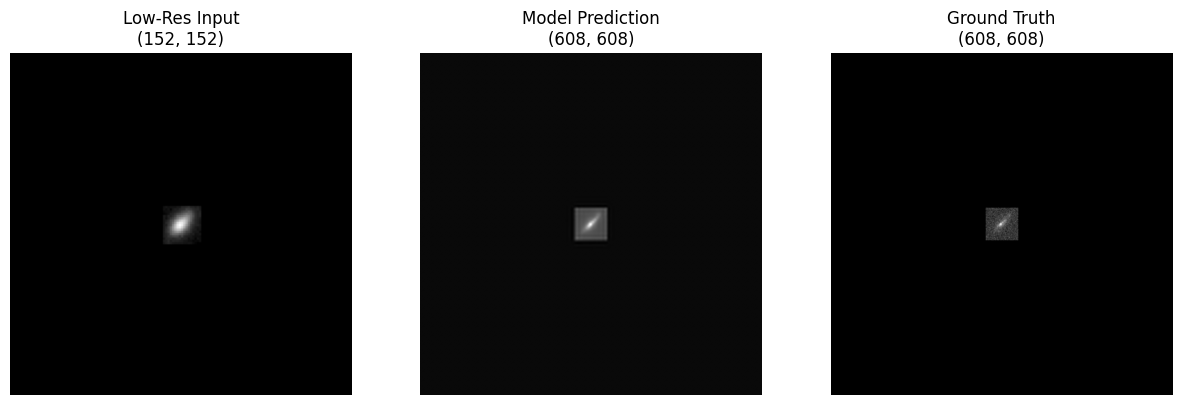

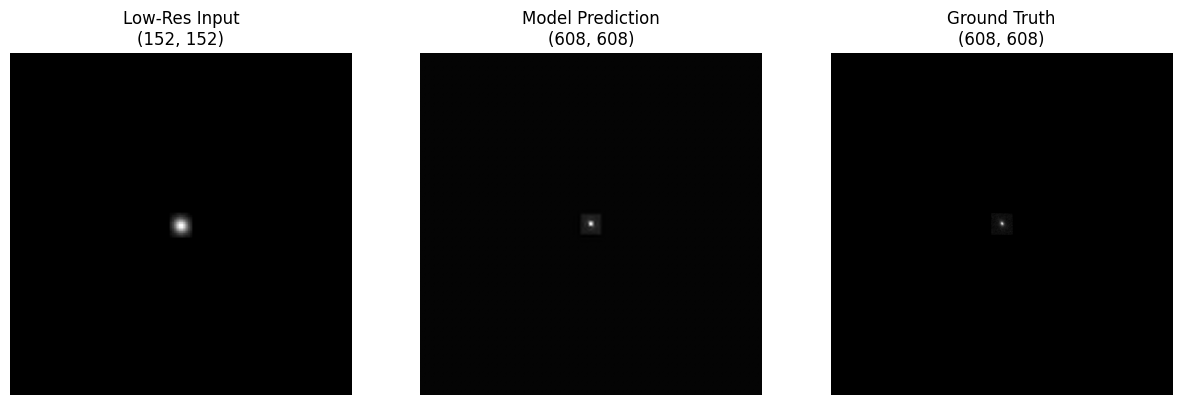

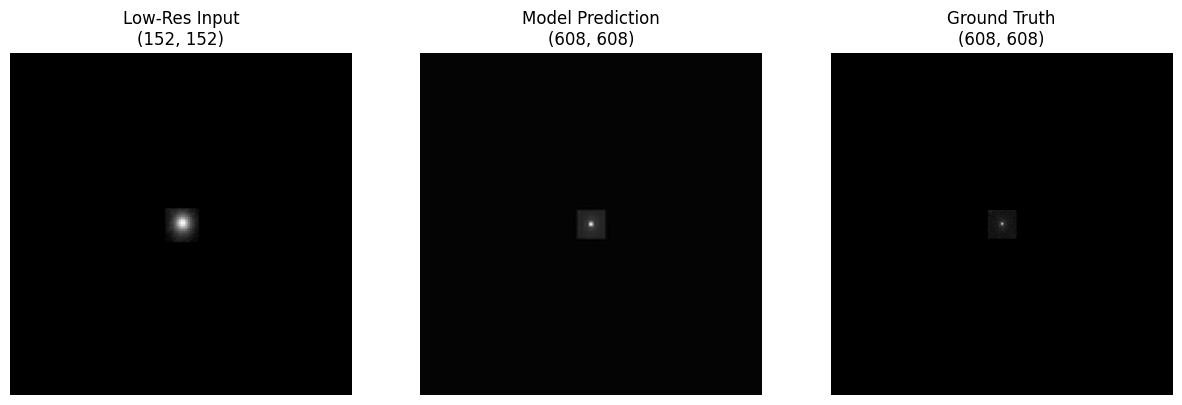

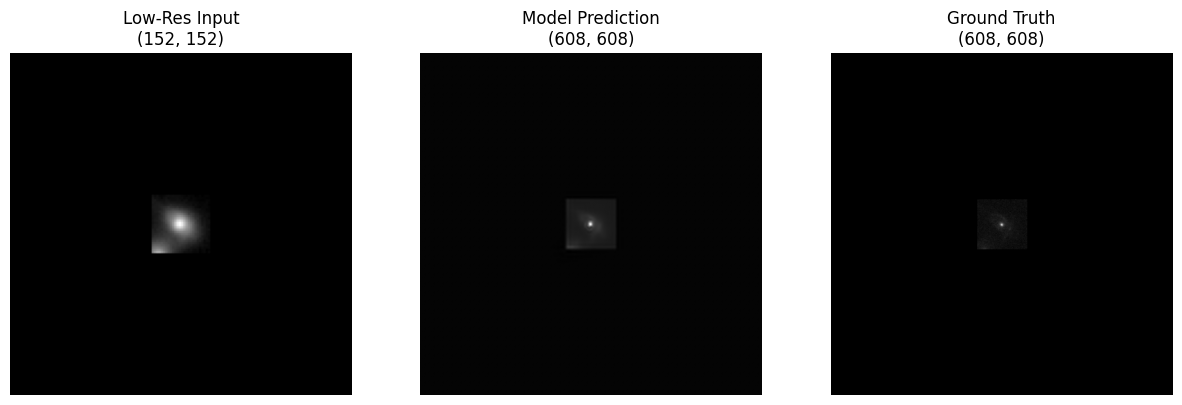

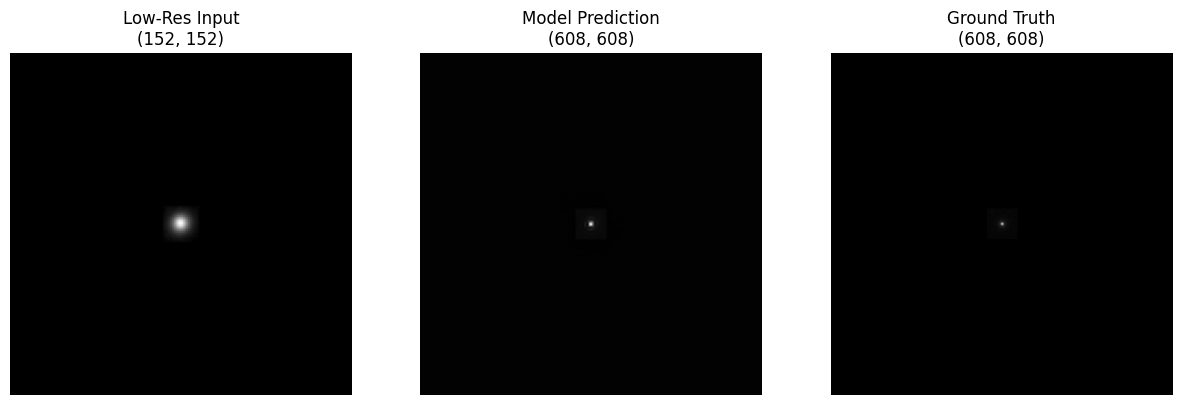

In [ ]:
# Visualizar resultados en el conjunto de test
visualize_results(ddpm_model_superres, test_loader, num_examples=5)